#### Learning of Structured Data - Portfolio  2
---
*Group 1* - Kilian Hümmer, Fikrat Mutallimov, Surajkumar DiVarma, Max Werner and Phuoc Nguyen Pham

In [2]:
from Bio import SeqIO
from Bio import pairwise2
from Bio import Align
import swalign
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklvq import GMLVQ
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report


**Exercise1: 'Data set'**

Create a data set import script
* Load the protein sequence data set in the *.fasta* format. The numbers in the square
brackets correspond to class labels.

    *Hint: Search for the python package ‘biopython’*
* Utilize the Smith-Waterman algorithm to calculate an alignment score for two
sequences

    *Hint: There are a lot of pre-existing implementations, you don’t have to implement
it from scratch!*

In [62]:
# load data and extract the labels

seq_records = []
labels = []
for seq_record in SeqIO.parse("sequences.fasta", "fasta"):
    seq_records.append(seq_record)
    labels.append(int(seq_record.description.split('[')[1].split(']')[0]))
    print(seq_record.id)
    print(repr(seq_record.seq))
    print(len(seq_record))
len(seq_records)

Q5AV81
Seq('MVRIFITGSSDGIGQAAAKVLSEQGHSVVLHARNADRAASAQEAVPGAEAVLVG...PGG')
255
B1Y654
Seq('MTHALDTLALNQLFTEARTHNAWRDEPVAPELLRQLHELAKWGPTAMNCCPLRV...AVL')
197
P83288
Seq('MKIVLVFVCTLYLAQATYLSEQDVNEVSEFLEALDQANEAASEMVEAAETEEAR...YKN')
123
P39901
Seq('MIALSVCWQIVRYLCRIRQMXGLNAIEHSNYLRNYMGHLRQKLEQDPARPRHFI...FML')
65
P81907
Seq('NKTNLKQLKAEAARKKAXMQDMXTSVKVEPLXAXXNGAXRM')
41
A5UPS2
Seq('MARGNDIERVVADNRKARHDYFIEETYEAGIALTGSEIKSIRAGQVNLRGGYVR...TRR')
158
P0DN05
Seq('LVVSVTSRRVRFWDDFERDENFEEERPYLRNVKRACNDYKSSSYCRSVGSRNEC...GSC')
70
A0T0F5
Seq('MPKLKTRKAAAKRYKRTGTSNFLRRHAFKGHLLMKKSNKQKRKLSQTICVSRSD...LPY')
64
Q9X5U9
Seq('MTTITPIMVKELRERTGAAVMACKKALQETNGDMEAAIDLLRKAGDAKAAKRAG...GNR')
296
A2RMC2
Seq('MVLAKDLKSGMTFLNGEKLLRVMEASHHKPGKGNTIMRMKLKDVRSGSTFDDTY...KRA')
185
Q0VCN6
Seq('MTPLLFPLLLASLLPSSSCNKANKHKPWIEAEYQGIVMENDNTVLLNPPLFALD...HRY')
957
Q07874
Seq('MASWLSAKGKVYLPPAQPVARVLETDEYITGTSLYFHAGTERLLTVGHPYFPVK...IKQ')
516
Q2ITH2
Seq('MPSVSAVILKLAAAALSALLLSGVAANATSRIKDLANIEGVRQNQLIGYGLVVG...EVM')


5000

In [4]:
# we tested different sw alignment approaches to see which would perform best for the computation in exercise 2

In [5]:
match = 2
mismatch = -1
scoring = swalign.NucleotideScoringMatrix(match, mismatch)

sw = swalign.LocalAlignment(scoring_matrix=scoring)
alignment = sw.align(seq_records[0].seq, seq_records[1].seq)

alignment.dump()

Query: 160 WAGTA--VRSM---IV-CNLGHGDPA-G-L-RPRAPR-LDFDTA 193
           | |.|  |.||   .| ...| |..| | | || | | | .|.|
Ref  : 166 W-GNAIQVVSMHPGWVRTKMG-GVMAPGALDRP-A-RVL-ADWA 204

Score: 13
Matches: 19 (43.2%)
Mismatches: 25
CIGAR: 1M1I3M2D4M3D2M1D4M1I4M1D1M1D1M1D2M1I1M1I1M1D1M1I4M


In [6]:
def smith_waterman(seq1, seq2, match=2, mismatch=-1, gap_penalty=-1):
    rows = len(seq1) + 1
    cols = len(seq2) + 1
    matrix = [[0] * cols for _ in range(rows)]

    for i in range(1, rows):
        for j in range(1, cols):
            match_score = matrix[i-1][j-1] + (match if seq1[i-1] == seq2[j-1] else mismatch)
            delete_score = matrix[i-1][j] + gap_penalty
            insert_score = matrix[i][j-1] + gap_penalty
            matrix[i][j] = max(0, match_score, delete_score, insert_score)

    max_score = 0
    max_i, max_j = 0, 0
    for i in range(rows):
        for j in range(cols):
            if matrix[i][j] > max_score:
                max_score = matrix[i][j]
                max_i, max_j = i, j

    alignment_seq1 = ""
    alignment_seq2 = ""
    i, j = max_i, max_j
    while matrix[i][j] != 0:
        if i > 0 and j > 0 and matrix[i][j] == matrix[i-1][j-1] + (match if seq1[i-1] == seq2[j-1] else mismatch):
            alignment_seq1 = seq1[i-1] + alignment_seq1
            alignment_seq2 = seq2[j-1] + alignment_seq2
            i -= 1
            j -= 1
        elif i > 0 and matrix[i][j] == matrix[i-1][j] + gap_penalty:
            alignment_seq1 = seq1[i-1] + alignment_seq1
            alignment_seq2 = '-' + alignment_seq2
            i -= 1
        elif j > 0 and matrix[i][j] == matrix[i][j-1] + gap_penalty:
            alignment_seq1 = '-' + alignment_seq1
            alignment_seq2 = seq2[j-1] + alignment_seq2
            j -= 1

    return alignment_seq1, alignment_seq2, max_score

seq1 = seq_records[0].seq
seq2 = seq_records[1].seq
alignment_result = smith_waterman(seq1, seq2)

print("Score:", alignment_result[2])

Score: 13


In [63]:
pairwise2.align.localms(seq_records[0].seq, seq_records[1].seq, 2, -1, -1, -1, one_alignment_only=True)[0].score

13.0

In [7]:
aligner = Align.PairwiseAligner()
aligner.mode = 'local'
aligner.match_score = 2
aligner.mismatch_score = -1
aligner.open_gap_score = -1
aligner.extend_gap_score = -1
alignments = aligner.align(seq_records[0].seq, seq_records[1].seq)
alignment.score

13

**Exercise2: 'Embedding'**

Use the loaded data to embed the protein sequences into a 100-dimensional vector space.

Use the 100 largest eigenvalues for the embedding.
* Construct a pair-wise similarity matrix using the Smith-Waterman alignment
* Implement an embedding into a 100-dimensional euclidean vector space
* Hint: you are allowed to assume symmetry (which is almost true)

In [9]:
# Bio.Align.PairwiseAligner() turned out to be the fastest approach

dims = 5000
seq_records_cropped = seq_records[0:dims]
matrix = np.zeros((dims, dims))
for i, seq_i in enumerate(seq_records_cropped):
    for j, seq_j in enumerate(seq_records_cropped):
        if(i <= j):
            # matrix[i][j] = sw.align(seq_i.seq, seq_j.seq).score
            #_, _, matrix[i][j] = smith_waterman(seq_i.seq, seq_j.seq)
            # matrix[i][j] = pairwise2.align.localms(seq_i.seq, seq_j.seq, 2, -1, -1, -1, one_alignment_only=True)[0].score
            matrix[i][j] = aligner.align(seq_i.seq, seq_j.seq).score
        else:
            matrix[i][j] = matrix[j][i]
    print("Iteration i: ", i)
matrix

Iteration i:  0
Iteration i:  1
Iteration i:  2
Iteration i:  3
Iteration i:  4
Iteration i:  5
Iteration i:  6
Iteration i:  7
Iteration i:  8
Iteration i:  9
Iteration i:  10
Iteration i:  11
Iteration i:  12
Iteration i:  13
Iteration i:  14
Iteration i:  15
Iteration i:  16
Iteration i:  17
Iteration i:  18
Iteration i:  19
Iteration i:  20
Iteration i:  21
Iteration i:  22
Iteration i:  23
Iteration i:  24
Iteration i:  25
Iteration i:  26
Iteration i:  27
Iteration i:  28
Iteration i:  29
Iteration i:  30
Iteration i:  31
Iteration i:  32
Iteration i:  33
Iteration i:  34
Iteration i:  35
Iteration i:  36
Iteration i:  37
Iteration i:  38
Iteration i:  39
Iteration i:  40
Iteration i:  41
Iteration i:  42
Iteration i:  43
Iteration i:  44
Iteration i:  45
Iteration i:  46
Iteration i:  47
Iteration i:  48
Iteration i:  49
Iteration i:  50
Iteration i:  51
Iteration i:  52
Iteration i:  53
Iteration i:  54
Iteration i:  55
Iteration i:  56
Iteration i:  57
Iteration i:  58
Iterati

array([[ 510.,   13.,   14., ...,   10.,    9.,    7.],
       [  13.,  394.,   10., ...,   14.,   10.,   12.],
       [  14.,   10.,  246., ...,   11.,    8.,    7.],
       ...,
       [  10.,   14.,   11., ...,  440.,   11.,   10.],
       [   9.,   10.,    8., ...,   11., 1012.,    9.],
       [   7.,   12.,    7., ...,   10.,    9.,  176.]])

In [10]:
np.save("matrix_default.npy", matrix)

In [48]:
similarities = np.load("matrix_default.npy")
similarities

array([[ 510.,   13.,   14., ...,   10.,    9.,    7.],
       [  13.,  394.,   10., ...,   14.,   10.,   12.],
       [  14.,   10.,  246., ...,   11.,    8.,    7.],
       ...,
       [  10.,   14.,   11., ...,  440.,   11.,   10.],
       [   9.,   10.,    8., ...,   11., 1012.,    9.],
       [   7.,   12.,    7., ...,   10.,    9.,  176.]])

In [49]:
# use embedding approach from the lecture

eigenvalues, eigenvectors = np.linalg.eigh(similarities)
embedding = similarities @ eigenvectors[:, -100:] @ np.diag(np.sqrt(np.abs(eigenvalues[-100:])))

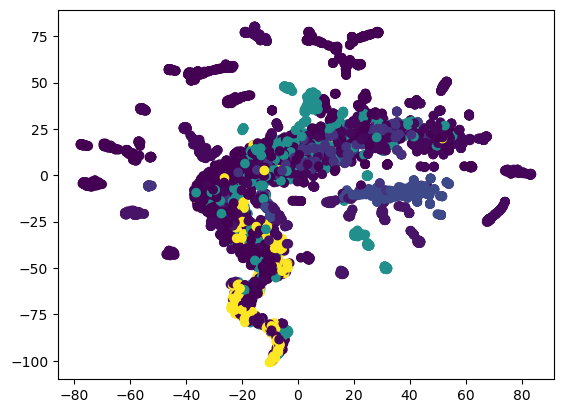

In [50]:
# visualize the embedding

tsne = TSNE(n_components=2, random_state=0)

projections = tsne.fit_transform(embedding)

plt.scatter(projections[:, 0], projections[:, 1], c=labels)

**Exercise3: 'Evaluation'**

* Evaluate the resulting embedding depending on your group **\*** and
provide a brief explanation of the algorithm you used. You may choose an algorithm yourself but we provide recommendations below.
* Try out different hyperparameter options, specifically for the Smith-Waterman
alignment. You can also try different embedding dimensions and normalizations
of the obtained vectors.

**\*** (Classification) Classify the protein sequences and calculate the accuracy score
w.r.t. the given class labels.

*Recommendation*: [GMLVQ](https://sklvq.readthedocs.io/en/stable/auto_examples/01_basic_usage/plot_01_glvq.html). Provide a full modeling and evaluation workflow. Other options are e.g. k-NN, Support Vector Machine, Random Forest



In [51]:
embedding_train, embedding_test, labels_train, labels_test = train_test_split(embedding, labels, test_size=0.2, random_state=42)

In [52]:
scaler = StandardScaler()
embedding_train_scaled = scaler.fit_transform(embedding_train)
embedding_test_scaled = scaler.transform(embedding_test)

In [53]:
gmlvq_classifier = GMLVQ(
    distance_type = "adaptive-squared-euclidean",
    activation_type = "swish",
    activation_params = {"beta": 5},
    solver_type = "waypoint-gradient-descent",
    solver_params = {"max_runs": 60, "step_size": 0.05},
    random_state = 0,
)

gmlvq_classifier.fit(embedding_train_scaled, labels_train)
predictions = gmlvq_classifier.predict(embedding_test_scaled)

print(classification_report(labels_test, predictions))

              precision    recall  f1-score   support

        3677       0.38      0.30      0.34        66
        3723       0.35      0.28      0.31        64
        3735       0.48      0.75      0.58        68
        3746       1.00      0.90      0.95        71
        3755       0.82      0.85      0.84        72
        4867       0.67      0.55      0.61        67
        5198       0.61      0.64      0.62        58
        5509       0.78      0.64      0.70        72
        5524       0.84      0.46      0.59        68
        8137       0.93      0.75      0.83        68
       16491       0.49      0.66      0.56        64
       22857       0.76      0.88      0.82        51
       46872       0.48      0.40      0.44        72
       46933       0.73      0.77      0.75        74
       90729       0.50      0.78      0.61        65

    accuracy                           0.64      1000
   macro avg       0.66      0.64      0.64      1000
weighted avg       0.66   

In [54]:
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(embedding_train_scaled, labels_train)
predictions = knn_classifier.predict(embedding_test_scaled)

print(classification_report(labels_test, predictions))

              precision    recall  f1-score   support

        3677       0.45      0.71      0.55        66
        3723       0.49      0.62      0.55        64
        3735       0.66      0.82      0.73        68
        3746       0.94      0.93      0.94        71
        3755       0.94      0.92      0.93        72
        4867       0.82      0.67      0.74        67
        5198       0.82      0.81      0.82        58
        5509       0.92      0.75      0.82        72
        5524       0.78      0.63      0.70        68
        8137       0.95      0.93      0.94        68
       16491       0.66      0.64      0.65        64
       22857       0.94      0.98      0.96        51
       46872       0.78      0.44      0.57        72
       46933       0.93      0.84      0.88        74
       90729       0.70      0.80      0.75        65

    accuracy                           0.76      1000
   macro avg       0.79      0.77      0.77      1000
weighted avg       0.79   

In [55]:
svm_classifier = SVC(gamma='auto')
svm_classifier.fit(embedding_train_scaled, labels_train)
predictions = svm_classifier.predict(embedding_test_scaled)

print(classification_report(labels_test, predictions))

              precision    recall  f1-score   support

        3677       0.64      0.32      0.42        66
        3723       1.00      0.38      0.55        64
        3735       0.33      0.74      0.46        68
        3746       1.00      0.90      0.95        71
        3755       1.00      0.78      0.88        72
        4867       0.96      0.33      0.49        67
        5198       1.00      0.60      0.75        58
        5509       0.88      0.53      0.66        72
        5524       1.00      0.46      0.63        68
        8137       1.00      0.76      0.87        68
       16491       0.40      0.81      0.54        64
       22857       0.80      0.94      0.86        51
       46872       0.33      0.42      0.37        72
       46933       0.93      0.69      0.79        74
       90729       0.37      0.88      0.52        65

    accuracy                           0.63      1000
   macro avg       0.78      0.63      0.65      1000
weighted avg       0.78   

In [56]:
rf_classifier = RandomForestClassifier(max_depth=30, random_state=0)
rf_classifier.fit(embedding_train_scaled, labels_train)
predictions = rf_classifier.predict(embedding_test_scaled)

print(classification_report(labels_test, predictions))

              precision    recall  f1-score   support

        3677       0.65      0.59      0.62        66
        3723       0.67      0.58      0.62        64
        3735       0.58      0.81      0.67        68
        3746       1.00      0.93      0.96        71
        3755       1.00      0.93      0.96        72
        4867       0.87      0.61      0.72        67
        5198       0.85      0.81      0.83        58
        5509       0.93      0.79      0.86        72
        5524       0.95      0.53      0.68        68
        8137       1.00      0.93      0.96        68
       16491       0.54      0.89      0.67        64
       22857       0.91      0.98      0.94        51
       46872       0.58      0.60      0.59        72
       46933       0.94      0.86      0.90        74
       90729       0.58      0.82      0.68        65

    accuracy                           0.78      1000
   macro avg       0.80      0.78      0.78      1000
weighted avg       0.81   

#### *We were able to achieve better classification accuracy with other alignment parameters for the similarities:*

In [57]:
# instead of using the default parameters, we experimented with others:

# aligner = PairwiseAligner()
# aligner.mode = 'local'
# aligner.match_score = 2
# aligner.mismatch_score = -1
# aligner.open_gap_score = -0.5
# aligner.extend_gap_score = -0.1

In [58]:
similarities = np.load("matrix_alternative.npy")
similarities

array([[ 510. ,  105.9,   74.1, ...,  102.9,  136.7,   61.4],
       [ 105.9,  394. ,   61.6, ...,   90.7,  107.3,   47.7],
       [  74.1,   61.6,  246. , ...,   60.9,   76.4,   40.5],
       ...,
       [ 102.9,   90.7,   60.9, ...,  440. ,  124. ,   53.5],
       [ 136.7,  107.3,   76.4, ...,  124. , 1012. ,   59.1],
       [  61.4,   47.7,   40.5, ...,   53.5,   59.1,  176. ]])

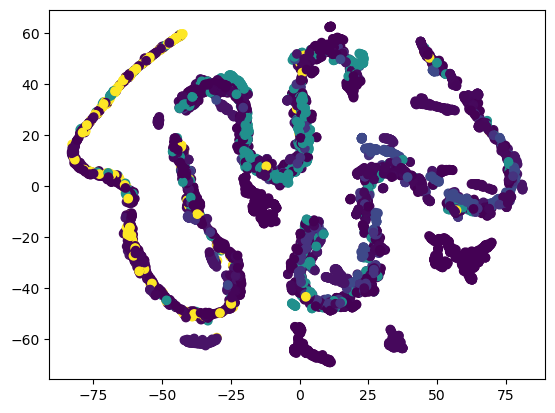

In [59]:
eigenvalues, eigenvectors = np.linalg.eigh(similarities)
embedding = similarities @ eigenvectors[:, -100:] @ np.diag(np.sqrt(np.abs(eigenvalues[-100:])))
projections = tsne.fit_transform(embedding)

plt.scatter(projections[:, 0], projections[:, 1], c=labels)

In [60]:
embedding_train, embedding_test, labels_train, labels_test = train_test_split(embedding, labels, test_size=0.2, random_state=42)
scaler = StandardScaler()
embedding_train_scaled = scaler.fit_transform(embedding_train)
embedding_test_scaled = scaler.transform(embedding_test)

In [61]:
gmlvq_classifier = GMLVQ(
    distance_type = "adaptive-squared-euclidean",
    activation_type = "swish",
    activation_params = {"beta": 5},
    solver_type = "waypoint-gradient-descent",
    solver_params = {"max_runs": 60, "step_size": 0.05},
    random_state = 0,
)

gmlvq_classifier.fit(embedding_train_scaled, labels_train)
predictions = gmlvq_classifier.predict(embedding_test_scaled)

print(classification_report(labels_test, predictions))

              precision    recall  f1-score   support

        3677       0.59      0.61      0.60        66
        3723       0.71      0.53      0.61        64
        3735       0.74      0.94      0.83        68
        3746       0.96      0.94      0.95        71
        3755       0.91      0.83      0.87        72
        4867       0.69      0.69      0.69        67
        5198       0.67      0.60      0.64        58
        5509       0.72      0.64      0.68        72
        5524       0.78      0.62      0.69        68
        8137       0.90      0.94      0.92        68
       16491       0.61      0.80      0.69        64
       22857       0.93      0.84      0.89        51
       46872       0.53      0.44      0.48        72
       46933       0.90      0.97      0.94        74
       90729       0.58      0.74      0.65        65

    accuracy                           0.74      1000
   macro avg       0.75      0.74      0.74      1000
weighted avg       0.75   

*The default approach just reached an accuracy of 0.64.*

*We also obtained separately how the accuracy depends on the amount of dimensions used:*

Text(0.5, 1.0, 'Accuracy versus Number of Dimensions')

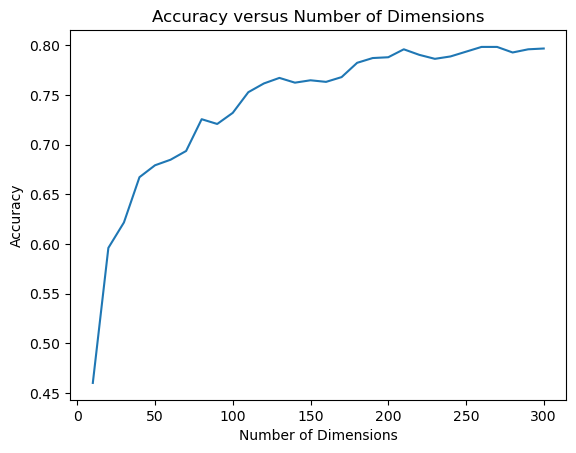

In [67]:
accuracies = np.load("accuracies_alternative.npy")

plt.plot(range(10, 301, 10), accuracies)
plt.xlabel("Number of Dimensions")
plt.ylabel("Accuracy")
plt.title("Accuracy versus Number of Dimensions")

*Within low dimensions between 0 and 300, while accuracy overall increases until 200 dimensions and does not improve further then.*